In [107]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp
from training.util import plot_losses
from training.regresssion import RegressionResults, plot_calibration
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
device = torch.device("cpu")

In [40]:
batch_size = 20
noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
learn_var = False
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

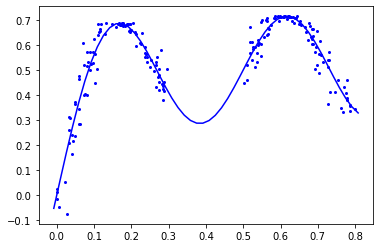

In [41]:
from training import toy
import matplotlib.pyplot as plt

torch.manual_seed(42)

trainset = toy.TrigonometricToyDataset(sample_count=200, noise=0.02, normalize=False, max=0.8, skip=0.2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

axis = plt.subplot()
trainset.plot_dataset(axis)

Epoch 0: loss -0.6137329936027527
Epoch 20: loss -0.8570796847343445
Epoch 40: loss -0.8684071898460388
Epoch 60: loss -0.8740668296813965
Epoch 80: loss -0.876422643661499


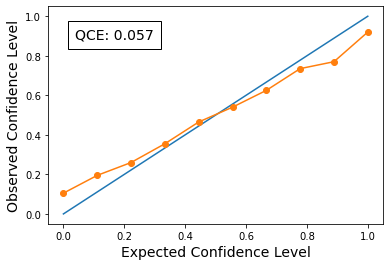

In [106]:
torch.manual_seed(42)
gp, gp_true_lml = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys, variance=torch.tensor(0.02))
gp_res = RegressionResults(trainloader, "GP", gp, 100, noise, device, False, 10)
plot_calibration(gp_res.quantile_ps, gp_res.observed_cdf, plt.subplot())

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


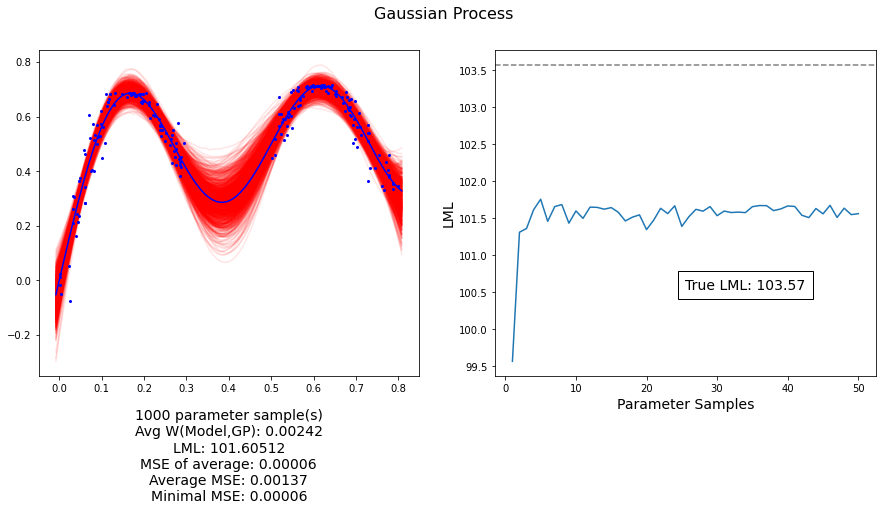

In [34]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml, variance=torch.tensor(0.02))

In [108]:
torch.manual_seed(42)
from training.pp import PointPredictor
pp = PointPredictor(layers)
pp.train(900, torch.nn.MSELoss(), sgd(lr=0.1), trainloader, batch_size, device, report_every_epochs=100)
pp_res = RegressionResults(trainloader, "Point Predictor", pp.infer, 1, noise, device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Epoch 0: loss 0.00422613974660635
Epoch 100: loss 0.0009698292124085128
Epoch 200: loss 0.0005992611986584961
Epoch 300: loss 0.0005091191851533949
Epoch 400: loss 0.0004392724367789924
Epoch 500: loss 0.00041032396256923676
Epoch 600: loss 0.00040288723539561033
Epoch 700: loss 0.00034768361365422606
Epoch 800: loss 0.00025960756465792656
Final loss 0.00019585229165386409


In [111]:
from training.swag import SwagModel
torch.manual_seed(42)

swag_config = {
    "start_epoch": 700,
    "update_every_batches": len(trainloader),
    "deviation_samples": 50
}
swag = SwagModel(layers, swag_config)
swag.train(900, torch.nn.MSELoss(), sgd(lr=0.1), trainloader, batch_size, device, report_every_epochs=100)
swag_res = RegressionResults(trainloader, "SWAG", swag.infer, 100, noise, device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Epoch 0: loss 0.00422613974660635
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.0009698292124085128
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 200: loss 0.0005992611986584961
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 300: loss 0.0005091191851533949
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 400: loss 0.0004392724367789924
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 500: loss 0.00041032396256923676
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 600: loss 0.00040288

In [128]:
from training.ensemble import Ensemble

torch.manual_seed(42)
ensemble = Ensemble([PointPredictor(layers) for _ in range(5)])
ensemble.train(900, torch.nn.MSELoss(), sgd(0.1), trainloader, batch_size, device, report_every_epochs=100)
ensemble_res = RegressionResults(trainloader, "Ensemble", ensemble.infer, 100, noise, device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Generated mod

In [126]:
from training.dropout import MonteCarloDropoutModule

torch.manual_seed(42)
mc_dropout = MonteCarloDropoutModule(layers, 0.1)
mc_dropout.train(900, torch.nn.MSELoss(), sgd(0.1), trainloader, batch_size, device, report_every_epochs=100)
mc_res = RegressionResults(trainloader, "Monte Carlo Dropout", mc_dropout.infer, 100, noise, device, fit_gaussian=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): FixableDropout()
  (2): ReLU()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): FixableDropout()
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): FixableDropout()
  (8): ReLU()
  (9): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Epoch 0: loss 0.0044493768364191055
Epoch 100: loss 0.0011582147562876344
Epoch 200: loss 0.0009447633638046682
Epoch 300: loss 0.0009005852043628693
Epoch 400: loss 0.0006931388634257019
Epoch 500: loss 0.00064275530166924
Epoch 600: loss 0.0006075199926272035
Epoch 700: loss 0.0005897027440369129
Epoch 800: loss 0.0005895697395317256
Final loss 0.0005832610186189413


In [130]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", layers)
bbb.train(900, torch.nn.MSELoss(reduction="sum"), sgd(lr=0.1), trainloader, batch_size, device, report_every_epochs=50, kl_rescaling=5)
bbb_res = RegressionResults(trainloader, "Bayes By Backprop", bbb.infer, 100, noise, device, fit_gaussian=False)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
4418 trainable parameters
Epoch 0: loss 135.15431213378906
Epoch 50: loss 2.8794174194335938
Epoch 100: loss 2.8104968070983887
Epoch 150: loss 3.258582353591919
Epoch 200: loss 2.7301888465881348
Epoch 250: loss 2.855786085128784
Epoch 300: loss 2.9936392307281494
Epoch 350: loss 2.908078193664551
Epoch 400: loss 2.77851939201355
Epoch 450: loss 2.855100631713867
Epoch 500: loss 2.8351144790649414
Epoch 550: loss 3.0319278240203857
Epoch 600: loss 3.095133066177368
Epoch 650: loss 2.811307430267334
Epoch 700: loss 2.8979544639587402
Epoch 750: loss 2.8248021602630615
Epoch 800: loss 3.060275077819824
Epoch 850: loss 2.7256369590759277
Final loss 2.9353466033935547


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorc

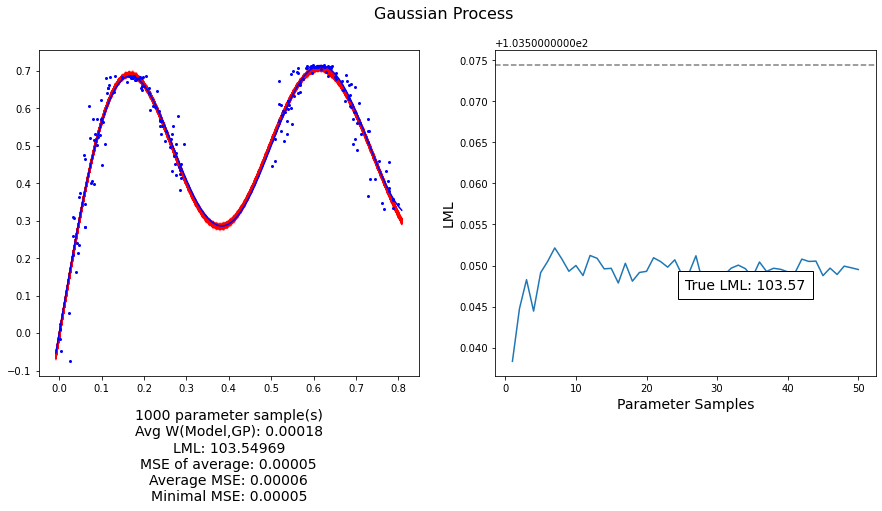

In [56]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml, variance=torch.tensor(0.02))

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


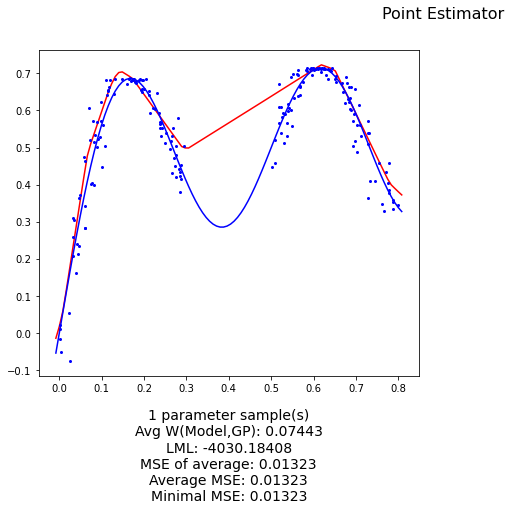

In [16]:
trainset.plot("Point Estimator", pp.infer, gp, noise, alpha=1, samples=1)

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


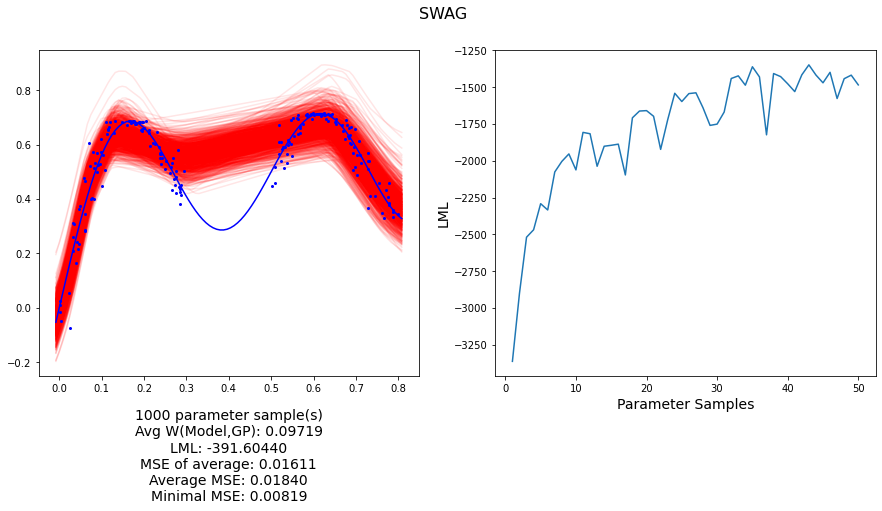

In [20]:
trainset.plot("SWAG", swag.infer, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), variance=torch.tensor(0.02))

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


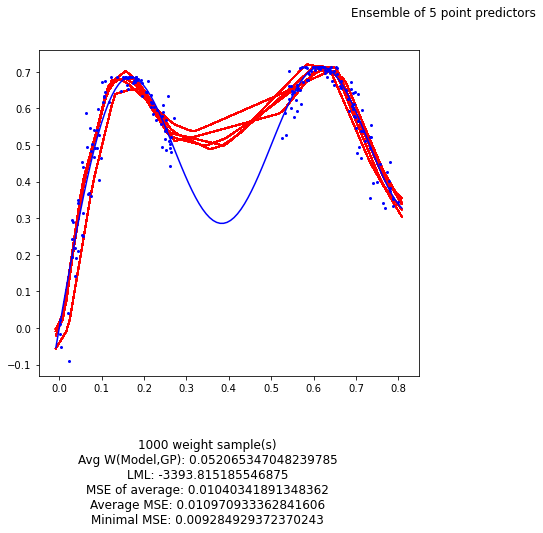

In [73]:
trainset.plot("Ensemble of 5 point predictors", ensemble, gp, alpha=0.1, samples=1000)

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


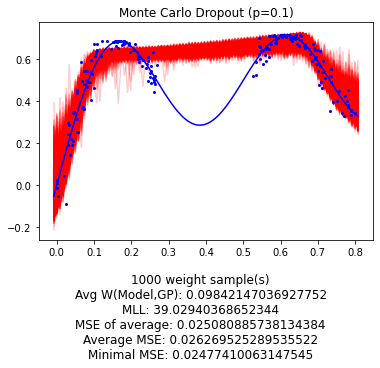

In [14]:
trainset.plot("Monte Carlo Dropout (p=0.1)", mc_dropout, gp, alpha=0.2, samples=1000)

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

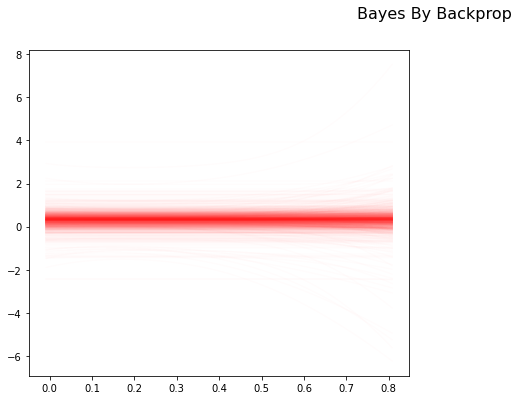

In [132]:
trainset.plot("Bayes By Backprop", bbb.infer, gp, alpha=0.01, samples=1000, variance=torch.tensor(0.02))

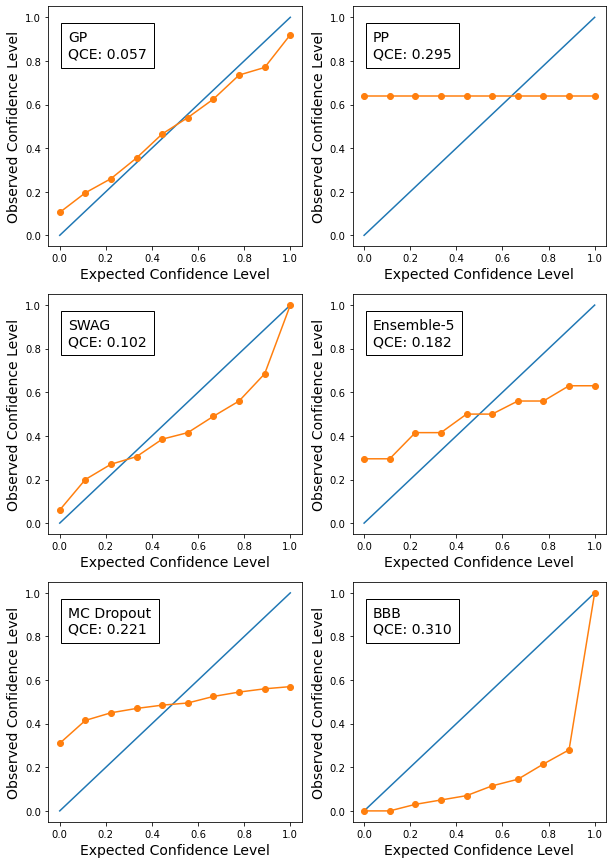

In [131]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
plot_calibration("GP", gp_res, axes[0,0])
plot_calibration("PP", pp_res, axes[0,1])
plot_calibration("SWAG", swag_res, axes[1,0])
plot_calibration("Ensemble-5", ensemble_res, axes[1,1])
plot_calibration("MC Dropout", mc_res, axes[2,0])
plot_calibration("BBB", bbb_res, axes[2,1])